In [11]:
from mesh import MeshHyperelasticity3D as Mesh

mesh = Mesh.load_mesh_hyperelasticity_3d(level=1)

In [12]:
%matplotlib widget

In [13]:
from math import e
import numpy as np
from scipy.sparse import csc_matrix

res_i = []
res_j = []
res_v = []

volumes = mesh.volumes
dphi = mesh.dphi
elems2nodes = np.array(mesh.elems2nodes, dtype=int)
mu = 769.2307692307692  # mesh.mu
lam = 1153.846153846154  # mesh.lambda_

for prism_node_i in range(4):
    for prism_node_j in range(4):
        grad_i = [dphi_loc[:, prism_node_i] for dphi_loc in dphi]
        grad_j = [dphi_loc[:, prism_node_j] for dphi_loc in dphi]
        for dofdim_i in range(3):
            for dofdim_j in range(3):
                res_i.append(elems2nodes[:, prism_node_i] * 3 + dofdim_i)
                res_j.append(elems2nodes[:, prism_node_j] * 3 + dofdim_j)

                if dofdim_i == dofdim_j:
                    res_mu = 2 * mu * sum([(grad_i[k] * grad_j[k] if k == dofdim_i else 0.5 * grad_i[k] * grad_j[k]) for k in range(3)])
                else:
                    res_mu = mu * grad_i[dofdim_j] * grad_j[dofdim_i]
                res_lam = lam * grad_i[dofdim_i] * grad_j[dofdim_j]

                res_v.append((res_mu + res_lam) * volumes.ravel())

res_v = np.concatenate(res_v)
res_i = np.concatenate(res_i)
res_j = np.concatenate(res_j)
sparse_matrix = csc_matrix((res_v, (res_i, res_j)))

In [14]:
u0_pos = np.array(mesh.nodes2coord, dtype=np.float64).ravel()
alpha = -1.047197551196598
nodes = np.where(mesh.nodes2coord[:, 0] == mesh.lx)[0]
u0_pos[nodes * 3 + 1] = (np.cos(alpha) * mesh.nodes2coord[nodes, 1] + np.sin(alpha) * mesh.nodes2coord[nodes, 2])
u0_pos[nodes * 3 + 2] = (-np.sin(alpha) * mesh.nodes2coord[nodes, 1] + np.cos(alpha) * mesh.nodes2coord[nodes, 2])
# u0_pos[nodes * 3 ] += 0.3
# u0_pos[nodes * 3 + 2] += 0.3
# u0_pos[nodes * 3 + 1] += 0.3

In [15]:
u0 = u0_pos - np.array(mesh.nodes2coord, dtype=np.float64).ravel()
b = - sparse_matrix @ u0

In [16]:
b_minim = b[mesh.dofsMinim.ravel()]
A_minim = sparse_matrix[mesh.dofsMinim.ravel()][:, mesh.dofsMinim.ravel()]

In [17]:
# Assume 'coords' is an N x 3 array of the node coordinates
coords = mesh.nodes2coord

# Number of nodes
N = coords.shape[0]

# Initialize rigid body modes matrix with 6 modes
rigid_modes = np.zeros((3 * N, 6))

# Translational modes
rigid_modes[::3, 0] = 1  # Translation in X
rigid_modes[1::3, 1] = 1  # Translation in Y
rigid_modes[2::3, 2] = 1  # Translation in Z

# Rotational modes about the X, Y, Z axes
rigid_modes[1::3, 3] = -coords[:, 2]
rigid_modes[2::3, 3] = coords[:, 1]

rigid_modes[::3, 4] = coords[:, 2]
rigid_modes[2::3, 4] = -coords[:, 0]

rigid_modes[::3, 5] = -coords[:, 1]
rigid_modes[1::3, 5] = coords[:, 0]

U = rigid_modes[mesh.dofsMinim.ravel(), :]

In [18]:
import pyamg

ml = pyamg.smoothed_aggregation_solver(A_minim, B=U, smooth='energy')


# Display hierarchy information
print(ml)

# Solve Ax=b
residuals = []
x_minim = ml.solve(b_minim, tol=1e-6, residuals=residuals)
print("Number of iterations:  {}\n".format(len(residuals)))

MultilevelSolver
Number of Levels:     3
Operator Complexity:   1.191
Grid Complexity:       1.177
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0        2133        64251 [83.96%]
     1         324        11376 [14.87%]
     2          54          900 [1.18%]

Number of iterations:  17



/usr/lib/python3.11/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


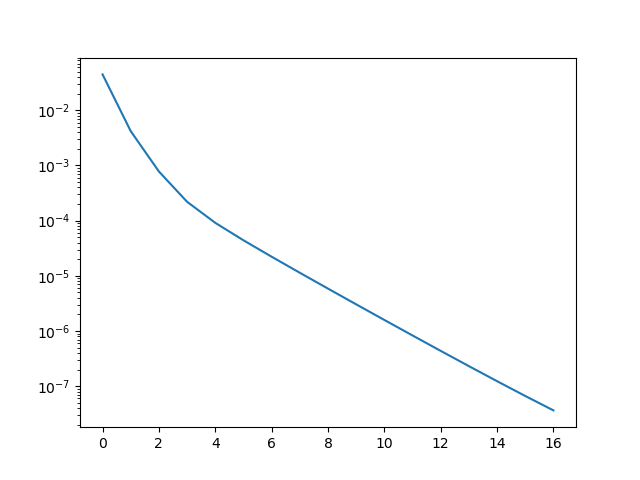

In [19]:
from matplotlib import pyplot as plt


plt.semilogy(residuals)

In [20]:
u0[mesh.dofsMinim.ravel()] = x_minim
res = u0 + np.array(mesh.nodes2coord, dtype=np.float64).ravel()

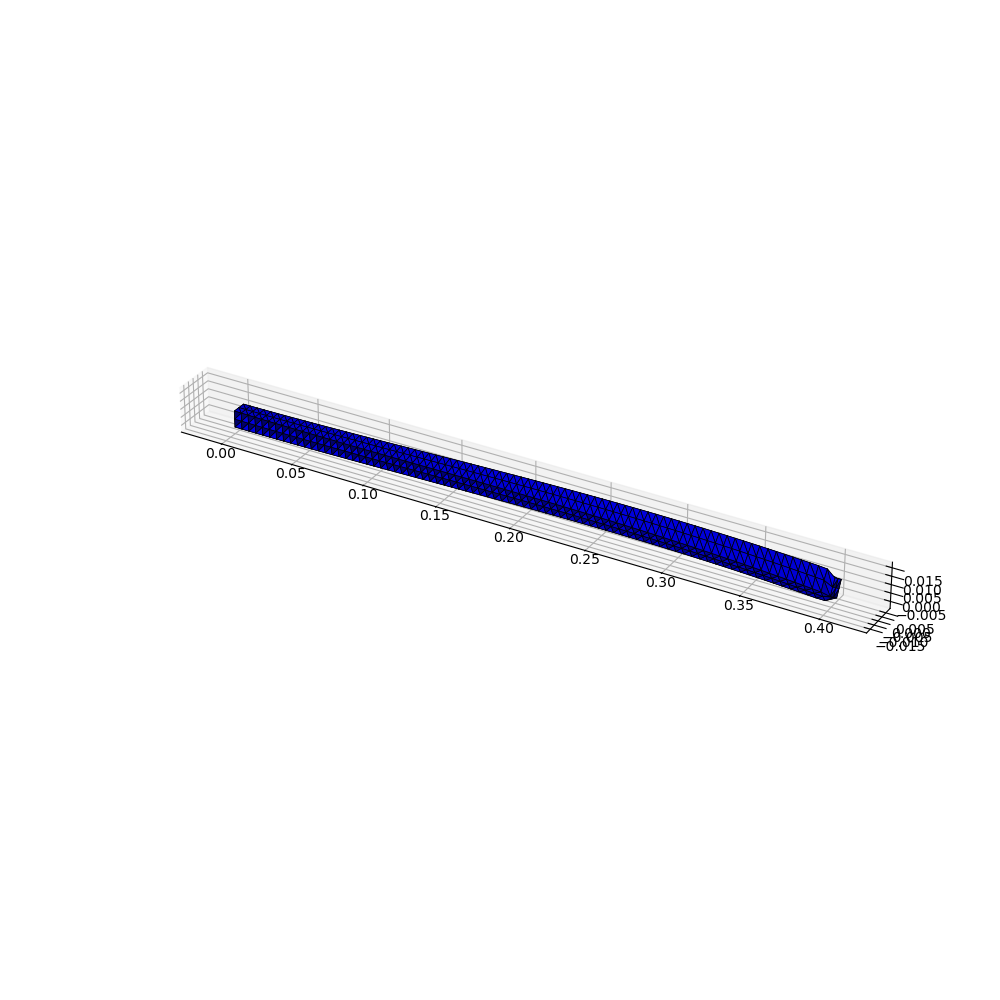

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax: Axes3D = fig.add_subplot(projection='3d')  # type: ignore
ax.plot_trisurf(res[::3], res[1::3], res[2::3], triangles=mesh.bfaces2nodes,
                color="b", edgecolor='k', linewidth=0.5, antialiased=True, shade=True)
data_ranges = [np.ptp(a) for a in [res[::3], res[1::3], res[2::3]]]
ax.set_box_aspect(data_ranges)  # Aspect ratio is 1:1:1